In [1]:
import boto3
import sagemaker
from sagemaker import Model
import os
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
print(f"SageMaker Role ARN: {role}")

SageMaker Role ARN: arn:aws:iam::796932308591:role/service-role/SageMaker-ExecutionRole-20250214T145019


In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
s3 = boto3.client('s3')

bucket = 'mitrailabs-personaclassification'
model_prefix = 'risk_prediction/data/'
response = s3.get_object(
    Bucket=bucket,
    Key=f"{model_prefix}clustered_data.csv"
)

X_processed = pd.read_csv(response['Body'])


In [5]:
import pandas as pd
from imblearn.over_sampling import SMOTE

def apply_smote(df, target_column, random_state=42):
    # Separate features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new DataFrame with resampled data
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled

X_processed = apply_smote(X_processed, ['Cluster'])

In [6]:
from sklearn.feature_selection import f_classif

X = X_processed.drop(columns=['Cluster', "target_default"])
y = X_processed['Cluster']

print("Cluster in df_normalized:", 'Cluster' in X_processed.columns)  # Should be True
print("Cluster in X:", 'Cluster' in X.columns)  # Should be False



f_scores, p_values = f_classif(X, y)

# Create a DataFrame to display results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort by F-Score (higher F-Score means more important)
feature_importance = feature_importance.sort_values(by='F-Score', ascending=False)

print(feature_importance)

Cluster in df_normalized: True
Cluster in X: False
                                            Feature        F-Score  \
31                               credit_utilization  180144.951037   
24                      last_borrowed_in_months_log  110647.242307   
36                            loan_amount_to_income   90264.350472   
7                           last_borrowed_in_months   77913.550514   
23                         last_amount_borrowed_log   59220.991731   
37                       n_accounts_to_credit_limit   37948.243265   
25                                 credit_limit_log   36832.499778   
38                 credit_utilization_x_fraud_score   28123.496415   
34                                 credit_available   23676.503084   
6                              last_amount_borrowed   22401.591589   
8                                      credit_limit   18790.248399   
12                                       real_state   11045.955521   
39                  real_state_avg_face

In [7]:
X.nunique().sort_values()


external_data_provider_credit_checks_last_month        4
application_time_in_funnel                           501
external_data_provider_fraud_score                  1001
last_borrowed_in_months                             3536
last_borrowed_in_months_log                         3536
facebook_profile                                    9214
external_data_provider_credit_checks_last_year      9251
real_state                                         10462
real_state_avg_facebook_profile                    10462
ok_since_log                                       13653
ok_since                                           13653
score_1                                            15570
n_issues                                           18542
n_issues_log                                       18542
n_accounts                                         19044
n_accounts_log                                     19044
state                                              19230
shipping_state                 

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.1)
print(len(X_train), len(X_test))
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in y_train:", y_train.isna().sum())
print("Infinite values in X:", np.isinf(y_train.values).sum())

55741 6194
NaN in X_train: 0
NaN in y_train: 0
Infinite values in X: 0


In [9]:
X_train.columns

Index(['score_1', 'score_3', 'score_4', 'score_5', 'score_6', 'risk_rate',
       'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit',
       'income', 'facebook_profile', 'state', 'real_state', 'ok_since',
       'n_accounts', 'n_issues', 'application_time_in_funnel',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_fraud_score', 'reported_income',
       'shipping_state', 'last_amount_borrowed_log',
       'last_borrowed_in_months_log', 'credit_limit_log', 'income_log',
       'ok_since_log', 'n_accounts_log', 'n_issues_log', 'reported_income_log',
       'credit_utilization', 'reported_income_div_income',
       'facebook_profile_times_income', 'credit_available',
       'income_per_account', 'loan_amount_to_income',
       'n_accounts_to_credit_limit', 'credit_utilization_x_fraud_score',
       'real_state_avg_facebook_pro

        score_1     score_3     score_4   score_5     score_6  risk_rate  \
49503  0.143003  231.104231   97.346701  0.474351   94.931807   0.263227   
61398  0.181345  395.915819  100.445819  0.456396  104.893758   0.330282   
17361  0.232212  330.000000  101.489878  0.669364  112.212359   0.340000   
12238  0.232212  250.000000   98.276883  0.677805   77.605688   0.330000   
28198  0.300101  550.000000   95.426888  0.059224  136.426423   0.460000   
21947  0.300101  450.000000   99.661522  0.318874   94.551957   0.430000   
45407  0.182581  397.838959   99.328038  0.672997  111.606497   0.336912   
43441  0.121516  375.657416   97.025144  0.712304  109.189481   0.205790   
2465   0.232212  580.000000   97.262164  0.153377  108.223221   0.280000   
57798  0.161685  427.773120  100.008192  0.538262   94.584910   0.291618   

       last_amount_borrowed  last_borrowed_in_months  credit_limit  \
49503           9741.406057                     36.0      0.000000   
61398           8748.90

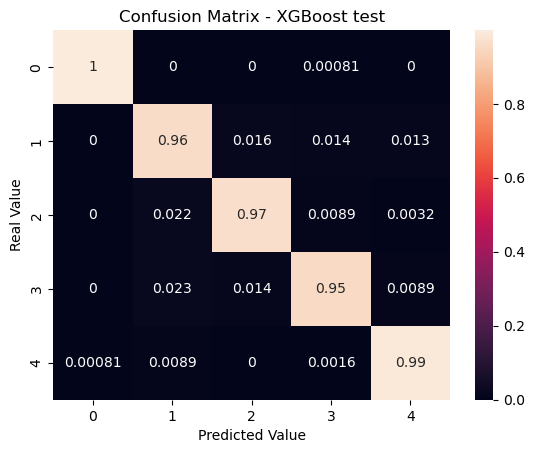

AUC Score: 0.9987064081689301


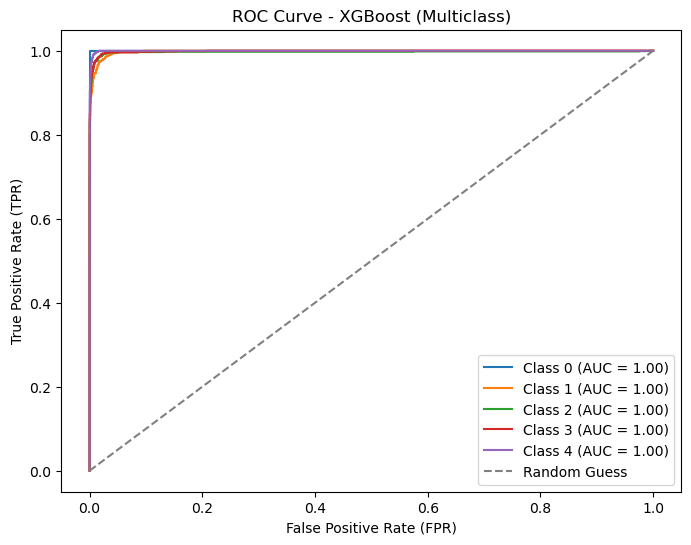

In [10]:
# final XGBoost model
xgb = XGBClassifier(
    max_depth=5, 
    learning_rate=0.01,  
    n_estimators=200, 
    gamma=1,  
    min_child_weight=6,  
    # subsample=0.8,  
    # colsample_bytree=0.8,  
    # reg_lambda=1,  
    # reg_alpha=0.1
)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# xgb = RandomForestClassifier(
#     n_estimators=200,  # Number of trees in the forest
#     max_depth=8,        # Maximum depth of the trees
#     #... other hyperparameters (e.g., min_samples_split, min_samples_leaf, etc.)...
#     random_state=42,     # For reproducibility
# )

# xgb = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, algorithm='SAMME', random_state=42)  # Adjust parameters
xgb.fit(X_train, y_train)
# prediction
# scaler = MinMaxScaler().fit(X_test)
X_test_xgb = X_test #scaler.transform(X_test)
print(X_test_xgb.head(10))
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost test')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()





from sklearn.preprocessing import label_binarize
y_pred_xgb = xgb.predict_proba(X_test_xgb)
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

auc_score = roc_auc_score(y_test_binarized, y_pred_xgb)
print("AUC Score:", auc_score)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_xgb[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend()
plt.show()

In [11]:
# import joblib

# xgb_model_path = 'saved/xgb_model.joblib'   
# joblib.dump(xgb, xgb_model_path)

# target_bucket = 'mitrailabs-personaclassification'
# target_prefix = 'risk_prediction/models'
# model_path = f'{target_prefix}/xgb_model.joblib'
# s3.upload_file(
#     xgb_model_path,
#     target_bucket,
#     model_path
# )
xgb_model_path = 'saved/xgb_model.json'  # Use .json for XGBoost's native format
xgb.save_model(xgb_model_path)  # Save in XGBoost's format

target_bucket = 'mitrailabs-personaclassification'
target_prefix = 'risk_prediction/models'
model_path = f'{target_prefix}/xgb_model.json'

s3.upload_file(
    xgb_model_path,
    target_bucket,
    model_path
)